In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from GPyEm import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)
from time import process_time 
import scipy
from scipy.optimize import minimize

In [2]:
from torch.nn import Parameter

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import pyro.ops.stats as stats

In [3]:
mode_weights = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/modes_weights.csv',index_col=0,delim_whitespace=False,header=0)

mode_weights

#mode_weights=mode_weights.drop(15,axis=0)
#mode_weights=mode_weights.drop(14,axis=0)

meshes=['01','02','03','04','05','06','07','08','09','10','11','12','13','14','16','17','18','19']

x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/input/xlabels_EP.txt',delim_whitespace=True,header=None)
x_labels=x_labels.values.flatten().tolist()+mode_weights.columns.tolist()

y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/output/ylabels.txt',delim_whitespace=True,header=None)


same_input=[]
same_output=[]

dif_input = []
dif_output=[]
dif_modes=[]

all_input_dif = []
all_output_dif=[]
all_x_dif=[]
for i in range(len(meshes)):
    val=meshes[i]
    
    same_in = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/same_X/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
    same_out = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/same_X/"+val+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values
    
    dif_in = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/"+val+"/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
    dif_out = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/"+val+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values
    
    modeweights = np.tile(mode_weights.iloc[i,:].values, (dif_in.shape[0],1))
    input_modes = np.concatenate((dif_in,modeweights),axis=1)
    same_input.append(torch.tensor(same_in))
    same_output.append(torch.tensor(same_out))
    dif_input.append(torch.tensor(dif_in))
    dif_output.append(torch.tensor(dif_out))
    dif_modes.append(torch.tensor(input_modes))

#all_input=pd.concat(all_input)
#all_output=pd.concat(all_output
#all_input.columns=x_labels
#all_output.columns=y_labels

In [4]:
train_input=[]
test_input = []
train_output=[]
test_output = []

train_input_modes=[]
test_input_modes = []
train_output_modes=[]
test_output_modes = []

for i in range(len(meshes)):

    X=dif_input[i]
    y=dif_output[i]
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=seed+i
    )
    train_input.append(X_train)
    test_input.append(X_test)
    train_output.append(y_train)
    test_output.append(y_test)
    
    X=dif_modes[i]
    y=dif_output[i]
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=seed+i
    )
    train_input_modes.append(X_train)
    test_input_modes.append(X_test)
    train_output_modes.append(y_train)
    test_output_modes.append(y_test)

    
    

In [5]:
emulator_ensemble = []
for i in range(len(meshes)):
    emulator_ensemble.append(GPE.ensemble(train_input[i],train_output[i],mean_func="linear",training_iter=1000))
               

0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1


# GP-LVM Tests

In [8]:
n_sims = 180

In [9]:
c=np.random.choice(range(180),n_sims,replace=False).tolist()

In [11]:
same_output[0][c,0][:,None].shape


torch.Size([180, 1])

In [95]:
A_TAT_all = same_output[0][c,[0]][:,None]

for i in range(len(same_output)-1):
    A_TAT_all=torch.cat((A_TAT_all,same_output[i+1][c,[0]][:,None]),axis=1)
V_TAT_all = same_output[0][c,[1]][:,None]
for i in range(len(same_output)-1):
    V_TAT_all=torch.cat((V_TAT_all,same_output[i+1][c,[1]][:,None]),axis=1)

In [97]:
y=torch.cat([A_TAT_all,V_TAT_all])

In [99]:
y.shape

torch.Size([360, 18])

In [15]:
pred=[]
for i in range(len(meshes)):
    pred.append(emulator_ensemble[i].predict(same_input[0]))

A_TAT_all = pred[0][c,[0]][:,None]

for i in range(len(same_output)-1):
    A_TAT_all=torch.cat((A_TAT_all,pred[i+1][c,[0]][:,None]),axis=1)
V_TAT_all = same_output[0][c,[1]][:,None]
for i in range(len(same_output)-1):
    V_TAT_all=torch.cat((V_TAT_all,pred[i+1][c,[1]][:,None]),axis=1)

y_emulated=torch.cat([A_TAT_all,V_TAT_all])

In [16]:
y_emulated.shape

torch.Size([360, 18])

In [109]:
((y_emulated-y)**2).mean(axis=0)

tensor([0.2752, 1.3569, 1.8682, 1.8745, 0.8676, 1.0857, 1.9719, 2.2949, 1.9147,
        3.6080, 1.5129, 1.8952, 2.7176, 1.5980, 1.9970, 1.4571, 2.0383, 1.3674],
       dtype=torch.float64)

In [17]:
y_emulated=y_emulated.detach()

In [18]:
feats=9

In [19]:
# we setup the mean of our prior over X
X_prior_mean = torch.zeros(y.size(1), feats).double()  # shape: 437 x 2

In [20]:
X = Parameter(X_prior_mean.clone())
kernel = gp.kernels.RBF(input_dim=feats, lengthscale=torch.ones(feats))

In [21]:
# we will use SparseGPRegression model with num_inducing=32;
# initial values for Xu are sampled randomly from X_prior_mean
Xu = stats.resample(X_prior_mean.clone(), 18)
gplvm = gp.models.SparseGPRegression(X, y, kernel, Xu, noise=torch.tensor(0.01), jitter=1e-5)

In [22]:
# we use `.to_event()` to tell Pyro that the prior distribution for X has no batch_shape
gplvm.X = pyro.nn.PyroSample(dist.Normal(X_prior_mean, 0.1).to_event())
gplvm.autoguide("X", dist.Normal)

In [23]:
gplvm.X_loc

Parameter containing:
tensor([[ 0.1848, -0.0561,  0.2082,  0.0615,  0.0381, -0.1013, -0.0010,  0.0213,
         -0.1376],
        [ 0.1279,  0.0986,  0.0101, -0.1707, -0.1553, -0.0494, -0.0466, -0.0305,
         -0.0275],
        [-0.0420, -0.0166,  0.2153,  0.1272,  0.0148, -0.1969, -0.0895, -0.1423,
          0.3529],
        [ 0.1719,  0.1257,  0.0584, -0.1351,  0.0594, -0.1999, -0.1103,  0.0423,
         -0.0897],
        [ 0.2183, -0.0038,  0.1343, -0.0723, -0.0561, -0.0644, -0.0563, -0.0278,
          0.0163],
        [-0.2894,  0.0943,  0.1472,  0.0729, -0.0199,  0.1059,  0.0644, -0.1697,
          0.0978],
        [ 0.0732, -0.0306, -0.0203,  0.1387, -0.0026, -0.0694, -0.1000, -0.1166,
          0.0529],
        [-0.0467,  0.0420, -0.0908,  0.0810, -0.0247, -0.0644,  0.2012, -0.0441,
          0.0362],
        [-0.1209,  0.0420,  0.0824, -0.0693, -0.1453, -0.0315,  0.0503,  0.0363,
         -0.1519],
        [-0.0592, -0.0692, -0.1016,  0.0759,  0.0753,  0.0124,  0.0463,  0.104

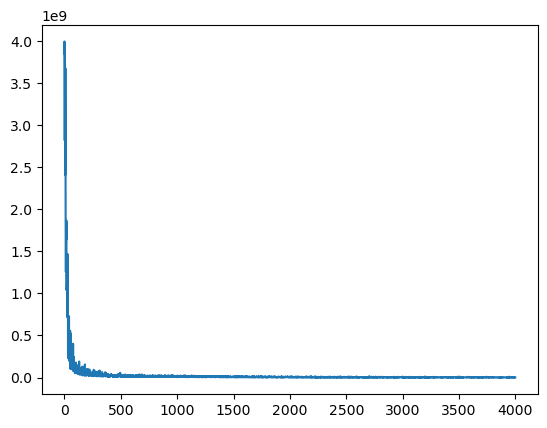

In [25]:
# note that training is expected to take a minute or so
losses = gp.util.train(gplvm, num_steps=4000)

# let's plot the loss curve after 4000 steps of training
plt.plot(losses)
plt.show()

In [29]:
gplvm.X_loc

Parameter containing:
tensor([[ 0.2933, -0.2097, -0.0583, -0.1967, -0.0026, -0.2627,  0.3120,  0.4582,
         -0.2568],
        [ 0.1508,  0.1988, -0.0023,  0.3539,  0.0261,  0.0652, -0.0266,  0.1131,
          0.0941],
        [-0.0391,  0.1099,  0.0038, -0.0414, -0.3242, -0.4268, -0.2487, -0.0365,
          0.1419],
        [ 0.0971, -0.0403,  0.0205, -0.0249, -0.2550, -0.0340,  0.0785,  0.0415,
         -0.0815],
        [-0.1113,  0.3629, -0.1085, -0.2935,  0.1612,  0.1485, -0.1041,  0.0748,
          0.2180],
        [-0.3340, -0.1493,  0.3906,  0.0790,  0.2282,  0.0677,  0.2682, -0.0905,
          0.1740],
        [-0.0492, -0.0919, -0.0421,  0.0050,  0.0904,  0.2568, -0.0697, -0.2036,
         -0.0192],
        [-0.3345,  0.1559, -0.0267, -0.1539, -0.0488,  0.0916, -0.2690, -0.3200,
          0.5881],
        [-0.1044,  0.1535,  0.0433,  0.0352, -0.1136, -0.0962, -0.3763, -0.1329,
         -0.0085],
        [ 0.1334, -0.0552,  0.0398,  0.4636,  0.0402, -0.2927,  0.1330,  0.062

In [30]:
pyro.clear_param_store()

In [31]:
gplvm.X_loc

Parameter containing:
tensor([[ 0.2933, -0.2097, -0.0583, -0.1967, -0.0026, -0.2627,  0.3120,  0.4582,
         -0.2568],
        [ 0.1508,  0.1988, -0.0023,  0.3539,  0.0261,  0.0652, -0.0266,  0.1131,
          0.0941],
        [-0.0391,  0.1099,  0.0038, -0.0414, -0.3242, -0.4268, -0.2487, -0.0365,
          0.1419],
        [ 0.0971, -0.0403,  0.0205, -0.0249, -0.2550, -0.0340,  0.0785,  0.0415,
         -0.0815],
        [-0.1113,  0.3629, -0.1085, -0.2935,  0.1612,  0.1485, -0.1041,  0.0748,
          0.2180],
        [-0.3340, -0.1493,  0.3906,  0.0790,  0.2282,  0.0677,  0.2682, -0.0905,
          0.1740],
        [-0.0492, -0.0919, -0.0421,  0.0050,  0.0904,  0.2568, -0.0697, -0.2036,
         -0.0192],
        [-0.3345,  0.1559, -0.0267, -0.1539, -0.0488,  0.0916, -0.2690, -0.3200,
          0.5881],
        [-0.1044,  0.1535,  0.0433,  0.0352, -0.1136, -0.0962, -0.3763, -0.1329,
         -0.0085],
        [ 0.1334, -0.0552,  0.0398,  0.4636,  0.0402, -0.2927,  0.1330,  0.062

In [32]:
# we setup the mean of our prior over X
X_prior_mean = torch.zeros(y_emulated.size(1), feats).double()  # shape: 437 x 2

In [33]:
X = Parameter(X_prior_mean.clone())
kernel = gp.kernels.RBF(input_dim=feats, lengthscale=torch.ones(feats))

In [34]:
# we will use SparseGPRegression model with num_inducing=32;
# initial values for Xu are sampled randomly from X_prior_mean
Xu = stats.resample(X_prior_mean.clone(), 18)
gplvm_emulated = gp.models.SparseGPRegression(X, y_emulated, kernel, Xu, noise=torch.tensor(0.01), jitter=1e-5)

In [35]:
# we use `.to_event()` to tell Pyro that the prior distribution for X has no batch_shape
gplvm_emulated.X = pyro.nn.PyroSample(dist.Normal(X_prior_mean, 0.1).to_event())
gplvm_emulated.autoguide("X", dist.Normal)

In [36]:
gplvm_emulated.X_loc

Parameter containing:
tensor([[ 0.0484, -0.0895, -0.0072, -0.0735,  0.0992, -0.1431,  0.1250, -0.0356,
         -0.0702],
        [-0.0582,  0.1147, -0.0290,  0.0754,  0.1548,  0.1013,  0.0968,  0.1744,
          0.1034],
        [-0.1765,  0.1179, -0.0665, -0.0440, -0.0499, -0.0750, -0.0246,  0.0245,
          0.0374],
        [-0.1374, -0.0202, -0.0063, -0.1768,  0.2258,  0.1108, -0.0952, -0.0390,
          0.0115],
        [ 0.0573, -0.0531, -0.1967,  0.0153, -0.0905,  0.0088, -0.0970, -0.0928,
          0.0172],
        [ 0.1067, -0.0457, -0.0983,  0.0866, -0.0503,  0.1303, -0.0306,  0.0007,
          0.1290],
        [ 0.0819, -0.1383,  0.0083, -0.0028,  0.0667,  0.0550, -0.0639, -0.1006,
         -0.1061],
        [ 0.1221, -0.1099,  0.0641, -0.0659, -0.1352,  0.1769, -0.0852,  0.1332,
          0.1519],
        [ 0.0597,  0.0945,  0.1052, -0.1255, -0.1116,  0.0546, -0.2392, -0.0825,
         -0.0029],
        [ 0.0208,  0.0063, -0.0441, -0.0479, -0.1041, -0.1713,  0.0730,  0.002

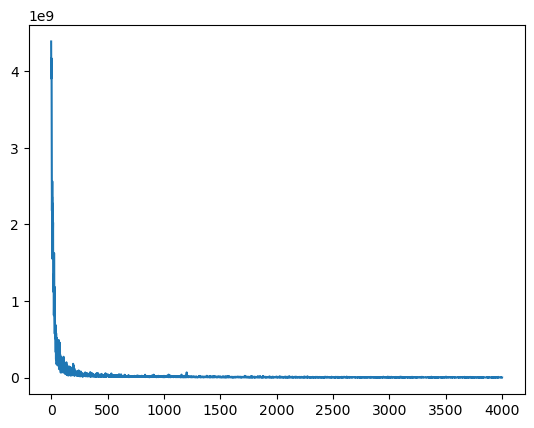

In [38]:
# note that training is expected to take a minute or so
losses = gp.util.train(gplvm_emulated, num_steps=4000)

# let's plot the loss curve after 4000 steps of training
plt.plot(losses)
plt.show()

In [39]:
gplvm_emulated.X_loc

Parameter containing:
tensor([[ 0.1839, -0.1709, -0.0058,  0.6417, -0.1543, -0.5640, -0.2354, -0.2486,
         -0.3300],
        [-0.0100,  0.2072,  0.0154,  0.0574,  0.2506, -0.0483,  0.0164,  0.0676,
         -0.0555],
        [-0.0677,  0.0634,  0.0308,  0.1230,  0.3643, -0.1192,  0.1408,  0.0187,
          0.2280],
        [-0.0686,  0.1213,  0.0999, -0.2692,  0.0801,  0.0730,  0.1941,  0.1476,
          0.4226],
        [-0.0007, -0.1388, -0.4722, -0.4446, -0.3250,  0.1116, -0.4365,  0.0283,
         -0.1824],
        [-0.0770,  0.1386, -0.0421, -0.3511,  0.0451,  0.2961,  0.0063, -0.0285,
          0.1779],
        [ 0.0941,  0.0918,  0.0485,  0.1709, -0.0355,  0.2518, -0.1601, -0.1166,
          0.1174],
        [-0.0534, -0.1126,  0.0905, -0.2720, -0.1988,  0.2504, -0.0789,  0.0537,
          0.2205],
        [-0.0931,  0.3211, -0.0658, -0.3154, -0.0897,  0.2493, -0.2993,  0.2801,
          0.3913],
        [-0.1009, -0.0681,  0.0400,  0.3161,  0.0237, -0.2312,  0.0039,  0.139

In [118]:
X.shape

torch.Size([18, 9])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


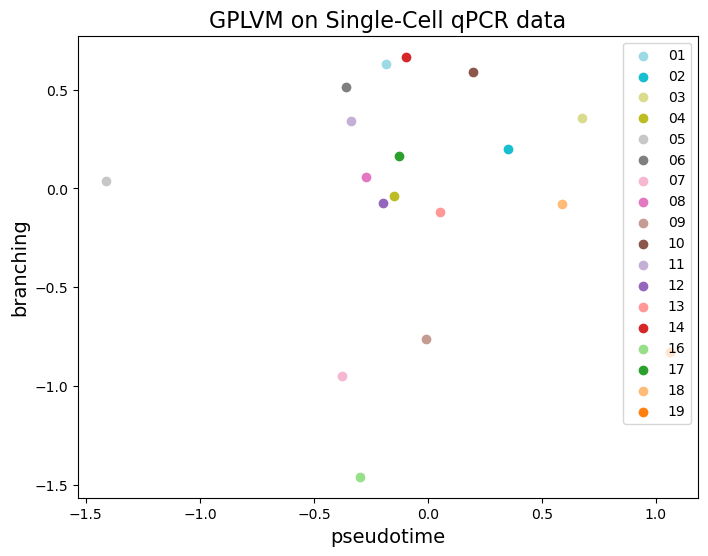

In [120]:
plt.figure(figsize=(8, 6))
colors = plt.get_cmap("tab20").colors[::-1]
labels = meshes

X = gplvm.X_loc
Xs = torch.split(X,1)
for i, label in enumerate(labels):
    print(i)
    X_i = Xs[i].detach().numpy()
    plt.scatter(X_i[:, 0], X_i[:, 1], c=[colors[i]], label=label)

plt.legend()
plt.xlabel("pseudotime", fontsize=14)
plt.ylabel("branching", fontsize=14)
plt.title("GPLVM on Single-Cell qPCR data", fontsize=16)
plt.show()

In [122]:
gp_modes=[]
d = {}
k = {}
X = {}
f = np.linspace(3,10,8)
for m in range(len(f)):

    feats=int(f[m])
    # we setup the mean of our prior over X
    X_prior_mean = torch.zeros(y.size(1), feats).double()  # shape: 437 x 2
    
    X["string{0}".format(m)] = Parameter(X_prior_mean.clone())
    k["string{0}".format(m)] = gp.kernels.RBF(input_dim=feats, lengthscale=torch.ones(feats))

    # we will use SparseGPRegression model with num_inducing=32;
    # initial values for Xu are sampled randomly from X_prior_mean
    d["string{0}".format(m)] = gp.models.GPRegression(X["string{0}".format(m)], y, k["string{0}".format(m)], noise=torch.tensor(0.01), jitter=1e-5)

    # we use `.to_event()` to tell Pyro that the prior distribution for X has no batch_shape
    d["string{0}".format(m)].X = pyro.nn.PyroSample(dist.Normal(X_prior_mean, 0.1).to_event())
    d["string{0}".format(m)].autoguide("X", dist.Normal)
    #gp.util.train(d["string{0}".format(m)], num_steps=4000)
    #gp_modes.append(d["string{0}".format(m)].X_loc)
    print(m)

0
1
2
3
4
5
6
7


In [124]:
for gpe in d:
    losses=gp.util.train(d[gpe], num_steps=4000)
    gp_modes.append(d[gpe].X_loc)


RuntimeError: The size of tensor a (3) must match the size of tensor b (9) at non-singleton dimension 1
Trace Shapes:     
 Param Sites:     
        X_loc 18 9
      X_scale 18 9
Sample Sites:     

In [126]:
k

{'string0': RBF(),
 'string1': RBF(),
 'string2': RBF(),
 'string3': RBF(),
 'string4': RBF(),
 'string5': RBF(),
 'string6': RBF(),
 'string7': RBF()}

In [128]:
#gp.util.train(d["string{0}".format(m)], num_steps=4000)
    #gp_modes.append(d["string{0}".format(m)].X_loc)

In [130]:
d['string4'].X

tensor([[-0.0864, -0.2087, -0.0565, -0.0308,  0.0197,  0.0297, -0.1684],
        [ 0.1701,  0.0555,  0.0245, -0.1218, -0.0025,  0.1440,  0.0573],
        [ 0.0449, -0.1054,  0.0036,  0.1084, -0.0311,  0.0148, -0.1427],
        [ 0.1836, -0.0213,  0.1259,  0.1106, -0.1768,  0.1719, -0.1448],
        [ 0.0380, -0.1197, -0.0869, -0.0885,  0.1343,  0.0037,  0.1049],
        [ 0.0012,  0.0277,  0.0861, -0.2412, -0.1281,  0.0987,  0.0025],
        [ 0.0480, -0.0106, -0.1169,  0.0851, -0.1399,  0.0353, -0.1015],
        [-0.0378,  0.0723,  0.0318, -0.1286,  0.0108, -0.1799, -0.1245],
        [ 0.0287, -0.0618, -0.0656, -0.0339, -0.1002, -0.0160, -0.0202],
        [ 0.1504,  0.0200,  0.0446, -0.0552, -0.0417,  0.0284,  0.0251],
        [-0.1381, -0.0720, -0.0759, -0.0125,  0.0218, -0.1688, -0.2158],
        [ 0.0025, -0.0308, -0.0862,  0.1266, -0.0911, -0.1413, -0.0358],
        [-0.0794, -0.0307, -0.0210,  0.0448, -0.0579, -0.1086,  0.0387],
        [ 0.0061,  0.2281,  0.0944,  0.0183,  0.026

In [132]:
gp_modes

[]

In [134]:
gplvm_emulated.X_loc[i]

tensor([ 0.0480, -0.2850, -0.0977, -0.3954,  0.1020,  0.3193,  0.1041,  0.2690,
         0.1765], dtype=torch.float64, grad_fn=<SelectBackward0>)

In [40]:
all_input_gp=[]
all_input_gp_em=[]
test_input_gp=[]
test_output_gp=[]
train_input_gp=[]
train_output_gp=[] 

test_input_gp_em=[]
test_output_gp_em=[]
train_input_gp_em=[]
train_output_gp_em=[] 
for i in range(len(meshes)):
    val=meshes[i]
    
    inputData = dif_input[i]
    modeweights = torch.tile(gplvm.X_loc[i,:], (inputData.shape[0],1))
    input_modes = torch.cat((inputData,modeweights),axis=1)
    all_input_gp.append(torch.tensor(input_modes))

    modeweights_em = torch.tile(gplvm_emulated.X_loc[i,:], (inputData.shape[0],1))
    input_modes_em = torch.cat((inputData,modeweights_em),axis=1)
    all_input_gp_em.append(torch.tensor(input_modes_em))
    
for i in range(len(meshes)):

    X=all_input_gp[i]
    y=dif_output[i]
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=seed+i
    )
    train_input_gp.append(X_train)
    test_input_gp.append(X_test)
    train_output_gp.append(y_train)
    test_output_gp.append(y_test)

    X=all_input_gp_em[i]
    y=dif_output[i]
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=seed+i
    )
    train_input_gp_em.append(X_train)
    test_input_gp_em.append(X_test)
    train_output_gp_em.append(y_train)
    test_output_gp_em.append(y_test)


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_93443/3119488228.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_input_gp.append(torch.tensor(input_modes))
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_93443/3119488228.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_input_gp_em.append(torch.tensor(input_modes_em))


In [41]:
reps = 5
train_p = np.linspace(100,800,8)
train_p=np.array([10,15,20,25,30,35,40,45,50])*17
R2_test = torch.zeros(len(train_p),reps,len(meshes),2)
R2_leftout= torch.zeros(len(train_p),reps,len(meshes),2)

R2_test_gp = torch.zeros(len(train_p),reps,len(meshes),2)
R2_leftout_gp= torch.zeros(len(train_p),reps,len(meshes),2)

R2_test_gp_em = torch.zeros(len(train_p),reps,len(meshes),2)
R2_leftout_gp_em= torch.zeros(len(train_p),reps,len(meshes),2)
for k in range(len(train_p)):
    for i in range(len(meshes)):
        for j in range(reps):
            X=torch.cat(train_input_modes[0:i]+train_input_modes[i+1:])[:,0:15]
            y=torch.cat(train_output_modes[:i]+train_output_modes[i+1:])
            X_train, X_test, y_train, y_test = train_test_split(
                X,
                y,
                train_size=int(train_p[k]),
                random_state=j
            )
            X_test= torch.cat(test_input_modes[0:i]+test_input_modes[i+1:])[:,0:15]
            y_test=torch.cat(test_output_modes[:i]+test_output_modes[i+1:])
            emulator=GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=1000)

            meanR, stdR = emulator.R2_sample(X_test,y_test,1000)
            R2_test[k,j,i,:]=meanR

            meanR, stdR=emulator.R2_sample(test_input_modes[i][:,0:15],test_output_modes[i],1000) 
            R2_leftout[k,j,i,:] = meanR
            print(R2_test[k,j,i,:])
            print(R2_leftout[k,j,i,:])
            
            X=torch.cat(train_input_gp[0:i]+train_input_gp[i+1:])
            y=torch.cat(train_output_gp[:i]+train_output_gp[i+1:])
            X_train, X_test, y_train, y_test = train_test_split(
                X,
                y,
                train_size=int(train_p[k]),
                random_state=j
            )
            X_test= torch.cat(test_input_gp[0:i]+test_input_gp[i+1:])
            y_test=torch.cat(test_output_gp[:i]+test_output_gp[i+1:])
            emulator=GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=1000)

            meanR, stdR = meanR, stdR = emulator.R2_sample(X_test,y_test,1000)
            R2_test_gp[k,j,i,:]=meanR

            meanR, stdR=emulator.R2_sample(test_input_gp[i],test_output_gp[i],1000) 
            R2_leftout_gp[k,j,i,:] = meanR
            print(R2_test_gp[k,j,i,:])
            print(R2_leftout_gp[k,j,i,:])


            X=torch.cat(train_input_gp_em[0:i]+train_input_gp_em[i+1:])
            y=torch.cat(train_output_gp_em[:i]+train_output_gp_em[i+1:])
            X_train, X_test, y_train, y_test = train_test_split(
                X,
                y,
                train_size=int(train_p[k]),
                random_state=j
            )
            X_test= torch.cat(test_input_gp_em[0:i]+test_input_gp_em[i+1:])
            y_test=torch.cat(test_output_gp_em[:i]+test_output_gp_em[i+1:])
            emulator=GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=1000)

            meanR, stdR = meanR, stdR = emulator.R2_sample(X_test,y_test,1000)
            R2_test_gp_em[k,j,i,:]=meanR

            meanR, stdR=emulator.R2_sample(test_input_gp[i],test_output_gp[i],1000) 
            R2_leftout_gp_em[k,j,i,:] = meanR
            print(R2_test_gp_em[k,j,i,:])
            print(R2_leftout_gp_em[k,j,i,:])

0
1


/Users/pmzcwl/Documents/GitHub/Calibration/GPyEm/GPE_ensemble.py:208: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3618.)
  prediction=torch.stack(prediction).T


tensor([0.9796, 0.9771])
tensor([-1.7301, -0.0435])
0
1
tensor([0.9829, 0.9723])
tensor([0.8638, 0.8552])
0
1
tensor([0.9875, 0.9755])
tensor([0.7847, 0.9273])
0
1
tensor([0.9867, 0.9788])
tensor([-0.2324,  0.1489])
0
1
tensor([0.9864, 0.9701])
tensor([0.7421, 0.7926])
0
1
tensor([0.9856, 0.9766])
tensor([-0.0731,  0.9017])
0
1
tensor([0.9867, 0.9773])
tensor([ 0.9459, -0.0200])
0
1
tensor([0.9806, 0.9700])
tensor([0.6827, 0.8086])
0
1
tensor([0.9845, 0.9771])
tensor([0.8176, 0.0603])
0
1
tensor([0.9847, 0.9811])
tensor([0.5364, 0.0854])
0
1
tensor([0.9761, 0.9627])
tensor([ 0.9189, -0.2585])
0
1
tensor([0.9839, 0.9740])
tensor([0.3764, 0.4094])
0
1
tensor([0.9828, 0.9702])
tensor([ 0.8407, -0.7940])
0
1
tensor([0.9838, 0.9533])
tensor([0.8482, 0.9082])
0
1
tensor([0.9874, 0.9592])
tensor([0.6284, 0.8845])
0
1
tensor([0.9860, 0.9755])
tensor([-0.6158,  0.8818])
0
1
tensor([0.9850, 0.9676])
tensor([0.9562, 0.7336])
0
1
tensor([0.9873, 0.9702])
tensor([0.9626, 0.7653])
0
1
tensor([0.9870

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/operators/_linear_operator.py:2155: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.. Using symeig method.
  warnings.warn(


tensor([0.9782, 0.9822])
tensor([ 0.6995, -0.4377])
0
1
tensor([0.9776, 0.9729])
tensor([0.7304, 0.9103])
0
1
tensor([0.9847, 0.9839])
tensor([0.6591, 0.8492])
0
1
tensor([0.9718, 0.9818])
tensor([ 0.9100, -0.2354])
0
1
tensor([0.9808, 0.9677])
tensor([0.8222, 0.7662])
0
1
tensor([0.9822, 0.9774])
tensor([0.6451, 0.8936])
0
1
tensor([0.9743, 0.9877])
tensor([ 0.9223, -0.2549])
0
1
tensor([0.9818, 0.9857])
tensor([0.8238, 0.9353])
0
1
tensor([0.9845, 0.9893])
tensor([0.7452, 0.9313])
0
1
tensor([0.9772, 0.9909])
tensor([ 0.8676, -0.2251])
0
1
tensor([0.9777, 0.9835])
tensor([0.6976, 0.8602])
0
1
tensor([0.9857, 0.9890])
tensor([0.7001, 0.6124])
0
1
tensor([0.9766, 0.9871])
tensor([ 0.8953, -0.6044])
0
1
tensor([0.9813, 0.9816])
tensor([0.7573, 0.7886])
0
1
tensor([0.9809, 0.9804])
tensor([0.6042, 0.8886])
0
1
tensor([0.9783, 0.9868])
tensor([-0.5376,  0.9094])
0
1
tensor([0.9753, 0.9750])
tensor([0.9697, 0.9231])
0
1
tensor([0.9852, 0.9805])
tensor([0.9788, 0.8190])
0
1
tensor([0.9809, 

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 31603.380859375 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


tensor([0.9789, 0.9469])
tensor([0.9307, 0.8792])
0
1
tensor([0.9756, 0.9816])
tensor([0.9214, 0.8834])
0
1
tensor([0.9820, 0.9793])
tensor([0.9040, 0.9229])
0
1
tensor([0.9808, 0.9870])
tensor([0.7243, 0.9463])
0
1
tensor([0.9800, 0.9809])
tensor([0.7067, 0.4423])
0
1
tensor([0.9816, 0.9790])
tensor([0.9656, 0.9301])
0
1
tensor([0.9818, 0.9839])
tensor([0.8543, 0.8359])
0
1
tensor([0.9838, 0.9863])
tensor([0.4700, 0.8547])
0
1
tensor([0.9806, 0.9872])
tensor([0.9657, 0.9068])
0
1
tensor([0.9785, 0.9874])
tensor([0.3356, 0.7495])
0
1
tensor([0.9829, 0.9785])
tensor([0.8209, 0.5800])
0
1
tensor([0.9799, 0.9816])
tensor([0.9523, 0.9337])
0
1
tensor([0.9810, 0.9910])
tensor([0.3314, 0.8660])
0
1
tensor([0.9804, 0.9885])
tensor([0.7914, 0.2518])
0
1
tensor([0.9810, 0.9868])
tensor([0.9568, 0.9158])
0
1
tensor([0.9786, 0.9876])
tensor([0.8202, 0.8972])
0
1
tensor([0.9753, 0.9823])
tensor([0.8547, 0.6768])
0
1
tensor([0.9812, 0.9777])
tensor([0.9586, 0.9100])
0
1
tensor([0.9791, 0.9835])
ten

In [71]:
i

17

In [73]:
meanR

tensor([0.1822, 0.3982])

In [75]:
800/17

47.05882352941177

In [77]:
R2_test.mean(axis=[1,2])[:8].detach()

tensor([[0.9857, 0.9757],
        [0.9919, 0.9849],
        [0.9949, 0.9896],
        [0.9963, 0.9921],
        [0.9970, 0.9937],
        [0.9975, 0.9945],
        [0.9978, 0.9951],
        [0.9981, 0.9955]])

In [79]:
R2_test_gp.mean(axis=[1,2])[:8].detach()

tensor([[0.9832, 0.9680],
        [0.9906, 0.9805],
        [0.9941, 0.9864],
        [0.9959, 0.9899],
        [0.9965, 0.9912],
        [0.9972, 0.9926],
        [0.9975, 0.9936],
        [0.9979, 0.9945]])

In [81]:
R2_leftout.mean(axis=[1,2])[:8].detach()

tensor([[0.5668, 0.7513],
        [0.4695, 0.7596],
        [0.5154, 0.7389],
        [0.5113, 0.7609],
        [0.6770, 0.7310],
        [0.6773, 0.7331],
        [0.6883, 0.7623],
        [0.7196, 0.7596]])

In [83]:
R2_leftout_gp.mean(axis=[1,2])[:8]

tensor([[0.6336, 0.2278],
        [0.6081, 0.4160],
        [0.4814, 0.3992],
        [0.4267, 0.2949],
        [0.4104, 0.3640],
        [0.4204, 0.3572],
        [0.4672, 0.4352],
        [0.3812, 0.4289]])

In [85]:
fontS=12

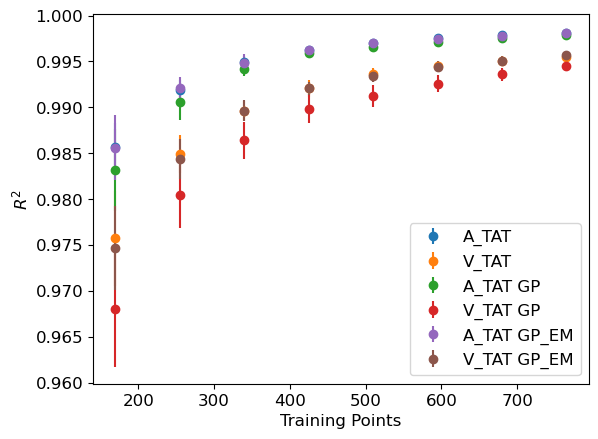

In [89]:
fig, ax = plt.subplots()


#plt.plot(t_size,R2.mean(axis=1).detach().numpy())
plt.errorbar(train_p[:8],R2_test.mean(axis=[1,2])[:8,0].detach().numpy(),fmt='o',yerr=R2_test.std(axis=[1,2])[:8,0].detach().numpy())
plt.errorbar(train_p[:8],R2_test.mean(axis=[1,2])[:8,1].detach().numpy(),fmt='o',yerr=R2_test.std(axis=[1,2])[:8,1].detach().numpy())

plt.errorbar(train_p[:8],R2_test_gp.mean(axis=[1,2])[:8,0].detach().numpy(),fmt='o',yerr=R2_test_gp.std(axis=[1,2])[:8,0].detach().numpy())
plt.errorbar(train_p[:8],R2_test_gp.mean(axis=[1,2])[:8,1].detach().numpy(),fmt='o',yerr=R2_test_gp.std(axis=[1,2])[:8,1].detach().numpy())

plt.errorbar(train_p[:8],R2_test_gp_em.mean(axis=[1,2])[:8,0].detach().numpy(),fmt='o',yerr=R2_test_gp_em.std(axis=[1,2])[:8,0].detach().numpy())
plt.errorbar(train_p[:8],R2_test_gp_em.mean(axis=[1,2])[:8,1].detach().numpy(),fmt='o',yerr=R2_test_gp_em.std(axis=[1,2])[:8,1].detach().numpy())


plt.legend(('A_TAT','V_TAT','A_TAT GP','V_TAT GP','A_TAT GP_EM','V_TAT GP_EM'),fontsize=fontS)
plt.xlabel('Training Points',fontsize=fontS)
plt.ylabel('$R^2$',fontsize=fontS)
plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
plt.savefig('figures/WeavingDTLatentNLeftin.pdf' )

In [ ]:
R2_test.mean(axis=[1,2])[:7,]

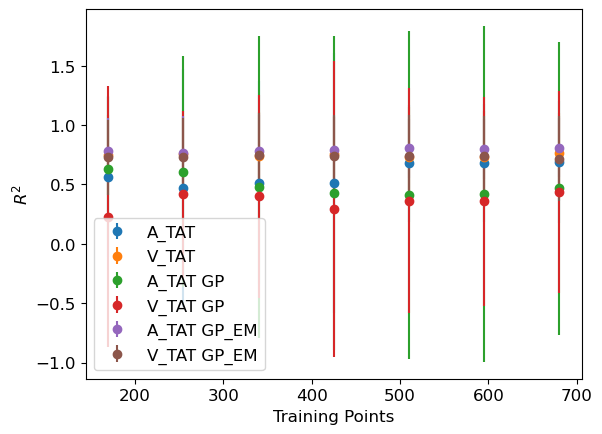

In [91]:
fig, ax = plt.subplots()


#plt.plot(t_size,R2.mean(axis=1).detach().numpy())
plt.errorbar(train_p[:7],R2_leftout.mean(axis=[1,2])[:7,0].detach().numpy(),fmt='o',yerr=R2_leftout.std(axis=[1,2])[:7,0].detach().numpy())
plt.errorbar(train_p[:7],R2_leftout.mean(axis=[1,2])[:7,1].detach().numpy(),fmt='o',yerr=R2_leftout.std(axis=[1,2])[:7,1].detach().numpy())

plt.errorbar(train_p[:7],R2_leftout_gp.mean(axis=[1,2])[:7,0].detach().numpy(),fmt='o',yerr=R2_leftout_gp.std(axis=[1,2])[:7,0].detach().numpy())
plt.errorbar(train_p[:7],R2_leftout_gp.mean(axis=[1,2])[:7,1].detach().numpy(),fmt='o',yerr=R2_leftout_gp.std(axis=[1,2])[:7,1].detach().numpy())

plt.errorbar(train_p[:7],R2_leftout_gp_em.mean(axis=[1,2])[:7,0].detach().numpy(),fmt='o',yerr=R2_leftout_gp_em.std(axis=[1,2])[:7,0].detach().numpy())
plt.errorbar(train_p[:7],R2_leftout_gp_em.mean(axis=[1,2])[:7,1].detach().numpy(),fmt='o',yerr=R2_leftout_gp_em.std(axis=[1,2])[:7,1].detach().numpy())

plt.legend(('A_TAT','V_TAT','A_TAT GP','V_TAT GP','A_TAT GP_EM','V_TAT GP_EM'),fontsize=fontS)
plt.xlabel('Training Points',fontsize=fontS)
plt.ylabel('$R^2$',fontsize=fontS)
plt.xticks(fontsize=fontS) 
plt.yticks(fontsize=fontS)
plt.savefig('figures/WeavingDTLatentNLeftout.pdf' )

In [59]:
np.linspace(1,9,9)

array([1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [80]:
len(meshes)

18

In [81]:
X_prior_mean

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)

In [82]:
y

tensor([[143.8950, 108.6710, 102.8900, 100.2590,  92.7805,  95.0455,  95.1232,
          92.1625,  98.0163, 121.0550, 112.5890,  85.1008, 107.1970, 108.3480,
          90.6607, 107.6410,  83.5767,  79.9982],
        [165.9600, 137.3160, 123.2540, 116.3570, 108.5430, 103.0250, 105.0770,
         100.9970, 108.1630, 131.8010, 130.4560, 100.0900, 125.6000, 123.6160,
         104.4840, 121.0420,  93.8847,  95.6497],
        [144.8360, 118.5100, 115.1750, 111.2700, 103.7620, 100.5810,  99.0901,
          96.1436, 106.2490, 130.1110, 117.8410,  92.7882, 116.0340, 117.8350,
          96.5547, 110.6310,  86.4705,  92.2660],
        [145.0060, 112.8790, 112.7560, 111.0230, 102.0860, 100.6960, 104.5640,
         100.4760, 108.9850, 129.6270, 118.6570,  94.7622, 115.7590, 120.7550,
          95.9507, 114.3700,  87.5293,  91.6855],
        [206.5860, 165.5050, 155.7970, 149.3620, 138.5510, 135.6540, 132.6090,
         127.2070, 137.4690, 172.8670, 166.1770, 123.3990, 160.5730, 158.3280,
         1

In [83]:
y=torch.cat([A_TAT_all,V_TAT_all])

In [85]:
gp_modes=[]
f = np.linspace(3,10,8)
for m in range(len(f)):
    
    feats=int(f[m])

    # we setup the mean of our prior over X
    X_prior_mean = torch.zeros(y.size(1), feats).double()  # shape: 437 x 2

    X = Parameter(X_prior_mean.clone())
    kernel = gp.kernels.RBF(input_dim=feats, lengthscale=torch.ones(feats))

    # we will use SparseGPRegression model with num_inducing=32;
    # initial values for Xu are sampled randomly from X_prior_mean
    Xu = stats.resample(X_prior_mean.clone(), 18)
    gplvm = gp.models.SparseGPRegression(X, y, kernel, Xu, noise=torch.tensor(0.01), jitter=1e-5)

    # we use `.to_event()` to tell Pyro that the prior distribution for X has no batch_shape
    gplvm.X = pyro.nn.PyroSample(dist.Normal(X_prior_mean, 0.1).to_event())
    gplvm.autoguide("X", dist.Normal)
    losses = gp.util.train(gplvm, num_steps=4000)
    gp_modes.append(gplvm.X_loc)
    print(m)

RuntimeError: The size of tensor a (3) must match the size of tensor b (9) at non-singleton dimension 1
Trace Shapes:     
 Param Sites:     
        X_loc 18 9
      X_scale 18 9
Sample Sites:     

In [ ]:

reps=5
R2_test = torch.zeros(len(f),reps,len(meshes),2)
R2_leftout = torch.zeros(len(f),reps,len(meshes),2)
for m in range(len(f)):
    X=gp_modes[m]
    all_input_gp=[]
    test_input_gp=[]
    test_output_gp=[]
    train_input_gp=[]
    train_output_gp=[] 
    for i in range(len(meshes)):
        val=meshes[i]

        inputData = dif_input[i]
        modeweights = torch.tile(X[i,:], (inputData.shape[0],1))
        input_modes = torch.cat((inputData,modeweights),axis=1)
        all_input_gp.append(torch.tensor(input_modes))
        print(input_modes.shape)
    for i in range(len(meshes)):

        X=all_input_gp[i]
        y2=dif_output[i]
        X_train, X_test, y_train, y_test = train_test_split(
            X,
            y2,
            test_size=0.2,
            random_state=seed+i
        )
        train_input_gp.append(X_train)
        test_input_gp.append(X_test)
        train_output_gp.append(y_train)
        test_output_gp.append(y_test)
        
    for i in range(len(meshes)):
        for j in range(reps):

            X=torch.cat(train_input_gp[0:i]+train_input_gp[i+1:])
            y2=torch.cat(train_output_gp[:i]+train_output_gp[i+1:])
            X_train, X_test, y_train, y_test = train_test_split(
                X,
                y2,
                train_size=int(45*17),
                random_state=j
            )
            X_test= torch.cat(test_input_gp[0:i]+test_input_gp[i+1:])
            y_test=torch.cat(test_output_gp[:i]+test_output_gp[i+1:])
            emulator=GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=1000)

            meanR, stdR = meanR, stdR = emulator.R2_sample(X_test,y_test,1000)
            R2_test[m,j,i,:]=meanR

            meanR, stdR=emulator.R2_sample(test_input_gp[i],test_output_gp[i],1000) 
            R2_leftout[m,j,i,:] = meanR
            print(R2_test[m,j,i,:])
            print(R2_leftout[m,j,i,:])


1
tensor([0.9973, 0.9935])
tensor([0.8573, 0.1113])
0
1
tensor([0.9978, 0.9934])
tensor([0.9541, 0.9185])
0
1
tensor([0.9981, 0.9940])
tensor([0.9328, 0.9176])
0
1
tensor([0.9981, 0.9928])
tensor([0.9402, 0.8475])
0
1
tensor([0.9982, 0.9926])
tensor([0.9287, 0.9228])
0
1
tensor([0.9978, 0.9936])
tensor([0.9476, 0.9319])
0
1
tensor([0.9972, 0.9941])
tensor([0.9804, 0.9305])
0
1
tensor([0.9982, 0.9942])
tensor([0.9823, 0.9341])
0
1
tensor([0.9978, 0.9931])
tensor([0.9817, 0.7482])
0
1
tensor([0.9980, 0.9940])
tensor([0.9733, 0.9264])
0
1
tensor([0.9973, 0.9929])
tensor([0.9786, 0.8548])
0
1
tensor([0.9977, 0.9952])
tensor([0.9928, 0.8489])
0
1
tensor([0.9981, 0.9937])
tensor([0.9860, 0.8794])
0
1
tensor([0.9974, 0.9946])
tensor([0.9913, 0.8127])
0
1
tensor([0.9977, 0.9943])
tensor([0.9924, 0.8556])
0
1
tensor([0.9977, 0.9937])
tensor([0.9915, 0.8684])
0
1
tensor([0.9973, 0.9940])
tensor([0.9694, 0.1767])
0
1
tensor([0.9981, 0.9938])
tensor([0.9171, 0.5440])
0
1
tensor([0.9975, 0.9940])
t

1
tensor([0.9975, 0.9952])
tensor([0.8891, 0.8438])
0
1
tensor([0.9977, 0.9949])
tensor([0.9447, 0.8839])
0
1
tensor([0.9974, 0.9944])
tensor([-0.4602,  0.5976])
0
1
tensor([0.9977, 0.9947])
tensor([0.2264, 0.5215])
0
1
tensor([0.9975, 0.9958])
tensor([ 0.0534, -2.2727])
0
1
tensor([0.9973, 0.9951])
tensor([-0.1928, -0.9778])
0
1
tensor([0.9975, 0.9945])
tensor([0.3803, 0.0257])
0
1
tensor([0.9973, 0.9948])
tensor([0.9149, 0.4992])
0
1
tensor([0.9966, 0.9952])
tensor([0.9246, 0.4013])
0
1
tensor([0.9974, 0.9960])
tensor([0.4872, 0.4621])
0
1
tensor([0.9977, 0.9955])
tensor([0.4070, 0.6757])
0
1
tensor([0.9974, 0.9952])
tensor([0.9663, 0.5481])
0
1
tensor([0.9977, 0.9945])
tensor([-0.3571,  0.8085])
0
1
tensor([0.9978, 0.9952])
tensor([-0.3871,  0.8449])
0
1
tensor([0.9977, 0.9954])
tensor([-0.3676,  0.7984])
0
1
tensor([0.9980, 0.9946])
tensor([-0.5218,  0.8377])
0
1
tensor([0.9977, 0.9944])
tensor([-0.3016,  0.8370])
0
1
tensor([0.9976, 0.9944])
tensor([0.6840, 0.9126])
0
1
tensor([0.

1
tensor([0.9979, 0.9949])
tensor([0.8641, 0.9209])
0
1
tensor([0.9978, 0.9948])
tensor([0.7906, 0.5354])
0
1
tensor([0.9985, 0.9960])
tensor([0.7429, 0.3957])
0
1
tensor([0.9978, 0.9947])
tensor([0.7523, 0.3760])
0
1
tensor([0.9978, 0.9955])
tensor([0.7632, 0.2160])
0
1
tensor([0.9979, 0.9954])
tensor([0.6653, 0.9046])
0
1
tensor([0.9978, 0.9954])
tensor([-1.8584,  0.9103])
0
1
tensor([0.9983, 0.9952])
tensor([-4.7986, -1.3967])
0
1
tensor([0.9981, 0.9953])
tensor([-3.8604,  0.9520])
0
1
tensor([0.9981, 0.9960])
tensor([-3.8507,  0.9353])
0
1
tensor([0.9981, 0.9951])
tensor([-2.0610,  0.8865])
0
1
tensor([0.9979, 0.9953])
tensor([0.9147, 0.7536])
0
1
tensor([0.9982, 0.9956])
tensor([0.8579, 0.4687])
0
1
tensor([0.9979, 0.9945])
tensor([0.8714, 0.8283])
0
1
tensor([0.9980, 0.9959])
tensor([0.9393, 0.7595])
0
1
tensor([0.9975, 0.9951])
tensor([0.7191, 0.7132])
0
1
tensor([0.9980, 0.9944])
tensor([0.2393, 0.9527])
0
1
tensor([0.9983, 0.9955])
tensor([0.7924, 0.9259])
0
1
tensor([0.9978, 

1
tensor([0.9978, 0.9953])
tensor([0.6201, 0.9190])
0
1
tensor([0.9974, 0.9955])
tensor([0.6583, 0.9628])
0
1
tensor([0.9978, 0.9950])
tensor([0.8820, 0.8976])
0
1
tensor([0.9972, 0.9951])
tensor([0.7532, 0.9013])
0
1
tensor([0.9979, 0.9961])
tensor([0.7700, 0.8729])
0
1
tensor([0.9976, 0.9956])
tensor([0.8517, 0.9444])
0
1
tensor([0.9975, 0.9955])
tensor([0.8681, 0.8938])
0
1
tensor([0.9975, 0.9956])
tensor([0.5868, 0.5250])
0
1
tensor([0.9972, 0.9953])
tensor([0.1752, 0.7718])
0
1
tensor([0.9978, 0.9958])
tensor([0.4938, 0.7077])
0
1
tensor([0.9978, 0.9953])
tensor([0.4002, 0.3669])
0
1
tensor([0.9976, 0.9957])
tensor([0.4804, 0.3601])
0
1
tensor([0.9978, 0.9955])
tensor([-3.6527,  0.1580])
0
1
tensor([0.9974, 0.9950])
tensor([-4.5444,  0.3022])
0
1
tensor([0.9979, 0.9959])
tensor([-1.5089,  0.2291])
0
1
tensor([0.9977, 0.9949])
tensor([-1.3476,  0.0078])
0
1
tensor([0.9978, 0.9949])
tensor([-0.9456,  0.1060])
0
1
tensor([0.9978, 0.9953])
tensor([0.8962, 0.8884])
0
1
tensor([0.9973, 

In [13]:
X

tensor([[ 0.6823,  0.2297,  7.5578,  ...,  0.4685,  4.3161, -0.2519],
        [ 0.7455,  0.4566,  7.6716,  ...,  0.3531,  5.4738, -0.2519],
        [ 0.6993,  0.2726,  6.3312,  ...,  0.3556,  3.0279, -0.2519],
        ...,
        [ 0.5787,  0.4716,  2.0716,  ...,  0.2841,  5.6434,  0.5360],
        [ 0.7148,  0.2119,  2.5516,  ...,  0.3632,  1.8089,  0.5360],
        [ 0.7724,  0.2202,  3.0978,  ...,  0.3888,  2.0067,  0.5360]],
       dtype=torch.float64)

In [68]:
R2_test_gp

tensor([[[[0.9832, 0.9766],
          [0.9867, 0.9726],
          [0.9860, 0.9787],
          ...,
          [0.9836, 0.9740],
          [0.9862, 0.9741],
          [0.9855, 0.9745]],

         [[0.9839, 0.9742],
          [0.9863, 0.9757],
          [0.9834, 0.9731],
          ...,
          [0.9880, 0.9785],
          [0.9897, 0.9765],
          [0.9871, 0.9771]],

         [[0.9807, 0.9759],
          [0.9828, 0.9776],
          [0.9852, 0.9661],
          ...,
          [0.9810, 0.9656],
          [0.9812, 0.9664],
          [0.9837, 0.9632]],

         [[0.9844, 0.9787],
          [0.9847, 0.9805],
          [0.9862, 0.9785],
          ...,
          [0.9871, 0.9739],
          [0.9909, 0.9732],
          [0.9888, 0.9701]],

         [[0.9828, 0.9597],
          [0.9845, 0.9675],
          [0.9868, 0.9669],
          ...,
          [0.9817, 0.9617],
          [0.9839, 0.9559],
          [0.9855, 0.9558]]],


        [[[0.9910, 0.9806],
          [0.9916, 0.9821],
          [0.9928

In [69]:
i

0

In [70]:
X_train.shape

torch.Size([510, 15])

In [71]:
y_train.shape

torch.Size([510, 2])

In [72]:
gplvm.X_loc

Parameter containing:
tensor([[-2.1950e-01, -3.9588e-02, -9.5533e-02, -1.0962e-01, -1.0015e-01,
          1.1485e-03, -1.8931e-02, -1.5053e-01,  5.7528e-02],
        [-5.8453e-02,  1.0517e-01,  4.2489e-02, -1.3357e-01, -2.0779e-01,
          1.2473e-01,  2.7866e-02,  3.4906e-02,  1.6401e-01],
        [ 2.8786e-02, -1.0925e-01, -1.0522e-01, -7.2013e-02,  1.3301e-01,
          2.0659e-01, -5.1307e-02,  5.5575e-02, -1.2567e-01],
        [ 6.1592e-02, -3.8234e-02, -2.6107e-02,  1.3040e-02,  7.9361e-03,
         -1.3746e-01,  1.6933e-01, -7.8600e-03,  2.1804e-01],
        [ 6.0545e-02, -1.4122e-01,  2.4177e-02,  1.6073e-02, -1.2098e-01,
         -6.6547e-02,  9.3613e-03,  8.7511e-02,  1.8359e-01],
        [ 8.3618e-02, -1.1521e-02, -1.3810e-01, -1.0721e-01,  2.5636e-01,
          6.5815e-02, -8.9664e-02,  2.0668e-02,  5.9149e-02],
        [-3.7121e-02,  7.2995e-02, -6.5655e-02, -1.3744e-01,  2.1161e-01,
         -1.2170e-02, -1.3249e-04, -5.5670e-02, -1.1212e-01],
        [-2.1569e-02, -1.1

In [73]:
f[m]

1.0

In [63]:
m

0

In [34]:
f = np.linspace(3,10,9)

<ErrorbarContainer object of 3 artists>

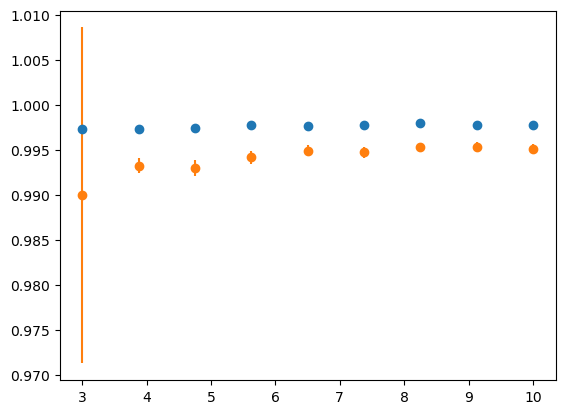

In [37]:
fig, ax = plt.subplots()


#plt.plot(t_size,R2.mean(axis=1).detach().numpy())
plt.errorbar(f,R2_test.mean(axis=[1,2])[:,0].detach().numpy(),fmt='o',yerr=R2_test.std(axis=[1,2])[:,0].detach().numpy())
plt.errorbar(f,R2_test.mean(axis=[1,2])[:,1].detach().numpy(),fmt='o',yerr=R2_test.std(axis=[1,2])[:,1].detach().numpy())


In [38]:
meshes=['01','02','03','04','05','06','07','08','09','10']

Ys=[]
Xs=[]

for i in range(len(meshes)):
    val=meshes[i]
    
    inputData = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case"+val+"/X.txt",index_col=None,delim_whitespace=True,header=None).values
    outputData = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case"+val+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values

    

    Xs.append(torch.tensor(inputData[0:200]))
    Ys.append(torch.tensor(outputData[0:200]))